# Bibliotecas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install unidecode
from unidecode import unidecode
import string
import liwc
import pandas as pd
import numpy as np
import glob
import re
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem.porter import *
from nltk.corpus import stopwords
!pip install -U gensim
import gensim
from gensim.models import KeyedVectors
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.doc2vec import TaggedDocument
from gensim.models.doc2vec import Doc2Vec
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 6.7 MB/s 


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 71.1 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


# Preparando o Doc2vec

Lendo e processando o texto

In [ ]:
#lê o arquivo de gêneros combinados
path = '/content/drive/MyDrive/Combined_json_part50.json'
df = pd.read_json(path)

In [ ]:
#preprocessamento
from nltk.corpus import stopwords
def process_text(text):
  text = text.lower().replace('\n', ' ').replace('\r', '').strip()
  text = re.sub(' +',' ',text)
  text = re.sub(r'[^\w\s]','',text)
  text = re.sub('[0-9]+', '', text)

  stop_words = set(stopwords.words('portuguese'))
  word_tokens = word_tokenize(text)
  filtered_sentence = [w for w in word_tokens if not w in stop_words]




  text = ' '.join(filtered_sentence)
  return text

In [ ]:
df = df['review'].dropna().apply(process_text) #tira os NaN e processa o texto

Preparando o modelo

In [ ]:
#define uma função para taggear os documentos para utiliza-los no doc2vec
def tagged_document(list_of_list_of_words):
  for i, list_of_words in enumerate(list_of_list_of_words):
    yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])
data_for_training = list(tagged_document(df))

In [ ]:

model_dbow= gensim.models.doc2vec.Doc2Vec(vector_size=1000, min_count=2, epochs=30) #estabelece os parametros
model_dbow.build_vocab(data_for_training) #constroi o vocabulario para o modelo
model_dbow.train(data_for_training, total_examples=model_dbow.corpus_count, epochs=model_dbow.epochs) #treina o modelo

Salvando o modelo

# Salvar o modelo

In [ ]:
fname = '/content/drive/MyDrive/meu_doc2vec'
model_dbow.save(fname)

# Carregando o Doc2Vec pronto

In [ ]:
fname = '/content/drive/MyDrive/meu_doc2vec'
model_dbow = Doc2Vec.load(fname)

# Pré-processamento

Lendo e processando o texto

In [ ]:
path2 = '/content/drive/MyDrive/Tese/Racing_json_rest_part_50.json'
df2 = pd.read_json(path2)

In [ ]:
#preprocessamento
def process_text(text):
  text = text.lower().replace('\n', ' ').replace('\r', '').strip()
  text = re.sub(' +',' ',text)
  text = re.sub(r'[^\w\s]','',text)
  text = re.sub('[0-9]+', '', text)

  stop_words = set(stopwords.words('portuguese'))
  word_tokens = word_tokenize(text)
  filtered_sentence = [w for w in word_tokens if not w in stop_words]




  text = ' '.join(filtered_sentence)
  return text

In [ ]:
#transforma a coluna weighted vote score que era string em float para utilizar no algoritmo
df2 = df2.astype({'weighted_vote_score': float}, errors='raise')

In [ ]:
#cria uma coluna de utilidade com score maior do que 0.5
df2['Helpful'] = np.where(df2['weighted_vote_score'] > 0.5, True, False)

In [ ]:
df2['weighted_vote_score']

74       0.583333
89       0.536785
107      0.666667
120      0.771310
123      0.654450
           ...   
96212    0.000000
96214    0.912740
96216    0.523810
96217    0.000000
96223    0.718310
Name: weighted_vote_score, Length: 3583, dtype: float64

In [ ]:
data = pd.DataFrame() #cria um dataframe

In [ ]:
data['Text'] = df2['review'].dropna().apply(process_text) #tira os NaN e preprocessa o texto

In [ ]:
data['Helpful'] = df2['Helpful']

In [ ]:
data.head()

,Text,Helpful
74,lembro primeiros jogos ps joguei engano ps épo...,True
89,queee nostalgia jogar jogooooo sendo antigo mu...,True
107,conheci jogo somente agora tava botando tanta ...,True
120,pra esmerilhar carro completamente termina eve...,True
123,old melhores jogos corrida demolição arcade jo...,True


In [ ]:
stop_words = nltk.corpus.stopwords.words('portuguese')

def remove_stopwords(text,stop_words):
  
  # tudo para caixa baixa
  s = str(text).lower() 

  tokens = word_tokenize(s)

  # remove stopwords, dígitos, caracteres especiais e pontuações
  v = [word for word in tokens if not word in stop_words and word.isalnum() and not word.isdigit()]

  return v

In [ ]:
df2 = data['Text']

In [ ]:
textolimpo= df2.apply(lambda x:remove_stopwords(x, stop_words))
textolimpo

74       [lembro, primeiros, jogos, ps, joguei, engano,...
89       [queee, nostalgia, jogar, jogooooo, sendo, ant...
107      [conheci, jogo, somente, agora, tava, botando,...
120      [pra, esmerilhar, carro, completamente, termin...
123      [old, melhores, jogos, corrida, demolição, arc...
                               ...                        
96212                                       [grande, jogo]
96214       [jogo, bom, aguardando, skin, cazé, amouranth]
96216    [jogo, legal, pra, divertir, sozinho, amigos, ...
96217                       [game, god, god, daora, jogar]
96223              [sai, daqui, crocodilo, safado, sa, fa]
Name: Text, Length: 3583, dtype: object

In [ ]:
textolimpo.reset_index(drop=True, inplace=True)

Preparando os vetores

In [ ]:
#cria uma lista contendo vetores inferidos a partir do doc2vec treinado
a = []
for i in textolimpo:
  b = model_dbow.infer_vector(i)
  a.append(b)

In [ ]:
b = np.array(a) #transforma a lista num numpy array

In [ ]:
b[0]

In [ ]:
vetores = pd.DataFrame(b)

In [ ]:
l = []
for i in range(1,1001):
  l.append(str('wv.'+ str(i)))
l

In [ ]:
vetores.columns= l #transforma a lista de vetores em colunas no dataframe

In [ ]:
vetores

,wv.1,wv.2,wv.3,wv.4,wv.5,wv.6,wv.7,wv.8,wv.9,wv.10,...,wv.991,wv.992,wv.993,wv.994,wv.995,wv.996,wv.997,wv.998,wv.999,wv.1000
0,-0.013191,0.107437,-0.101128,-0.023836,0.065465,0.072859,-0.022344,-0.053038,0.022696,-0.079012,...,-0.048623,0.001030,0.055860,0.017354,0.017503,0.022378,-0.032947,-0.063363,-0.033092,0.020337
1,-0.000177,0.000166,-0.000211,0.000280,0.000158,0.000062,-0.000462,0.000145,0.000174,-0.000493,...,-0.000359,-0.000377,-0.000365,0.000333,-0.000329,0.000356,-0.000341,-0.000330,-0.000477,-0.000034
2,-0.001358,0.006560,-0.011671,-0.003069,0.006176,0.001565,-0.001744,-0.001419,0.000983,-0.005481,...,-0.001420,-0.001735,-0.002404,-0.009788,-0.001572,0.002899,-0.001255,-0.018267,-0.004374,0.003315
3,0.000192,0.000072,-0.000326,-0.000199,-0.000009,0.000489,-0.000386,0.000117,-0.000305,0.000427,...,-0.000048,-0.000492,-0.000275,-0.000123,0.000476,-0.000144,0.000196,0.000393,-0.000242,0.000099
4,0.000302,-0.000011,0.000196,0.000471,-0.000209,0.000389,-0.000257,-0.000259,-0.000210,0.000396,...,0.000052,-0.000448,-0.000207,-0.000381,0.000058,0.000119,-0.000344,0.000251,0.000327,-0.000029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3578,-0.000036,-0.000403,-0.000275,0.000261,-0.000348,0.000128,0.000256,0.000120,0.000284,-0.000270,...,0.000364,-0.000485,-0.000166,-0.000379,0.000417,-0.000335,-0.000121,-0.000362,-0.000010,0.000267
3579,0.000151,-0.000144,0.000389,0.000036,0.000021,0.000288,0.000062,-0.000338,-0.000359,-0.000269,...,-0.000009,-0.000097,-0.000124,0.000320,0.000179,-0.000198,-0.000152,0.000209,-0.000327,0.000175
3580,0.000309,-0.000126,-0.000405,0.000097,-0.000336,0.000144,-0.000215,0.000164,-0.000024,0.000098,...,-0.000445,-0.000118,-0.000018,-0.000223,0.000167,-0.000404,-0.000479,-0.000246,0.000257,-0.000491
3581,-0.000041,-0.000192,0.000356,0.000231,-0.000035,-0.000454,0.000168,0.000271,-0.000188,-0.000385,...,0.000211,0.000162,0.000172,0.000106,-0.000414,0.000089,0.000471,0.000364,-0.000480,-0.000160


In [ ]:
dataframe = pd.DataFrame()

In [ ]:
data.reset_index(drop=True, inplace=True) #tira o indice do dataframe criado anteriormente

In [ ]:
resultfinal = pd.concat([data, vetores], axis=1, join='inner') #junta os dois dataframes

In [ ]:
resultfinal

,Text,Helpful,wv.1,wv.2,wv.3,wv.4,wv.5,wv.6,wv.7,wv.8,...,wv.991,wv.992,wv.993,wv.994,wv.995,wv.996,wv.997,wv.998,wv.999,wv.1000
0,lembro primeiros jogos ps joguei engano ps épo...,True,-0.013191,0.107437,-0.101128,-0.023836,0.065465,0.072859,-0.022344,-0.053038,...,-0.048623,0.001030,0.055860,0.017354,0.017503,0.022378,-0.032947,-0.063363,-0.033092,0.020337
1,queee nostalgia jogar jogooooo sendo antigo mu...,True,-0.000177,0.000166,-0.000211,0.000280,0.000158,0.000062,-0.000462,0.000145,...,-0.000359,-0.000377,-0.000365,0.000333,-0.000329,0.000356,-0.000341,-0.000330,-0.000477,-0.000034
2,conheci jogo somente agora tava botando tanta ...,True,-0.001358,0.006560,-0.011671,-0.003069,0.006176,0.001565,-0.001744,-0.001419,...,-0.001420,-0.001735,-0.002404,-0.009788,-0.001572,0.002899,-0.001255,-0.018267,-0.004374,0.003315
3,pra esmerilhar carro completamente termina eve...,True,0.000192,0.000072,-0.000326,-0.000199,-0.000009,0.000489,-0.000386,0.000117,...,-0.000048,-0.000492,-0.000275,-0.000123,0.000476,-0.000144,0.000196,0.000393,-0.000242,0.000099
4,old melhores jogos corrida demolição arcade jo...,True,0.000302,-0.000011,0.000196,0.000471,-0.000209,0.000389,-0.000257,-0.000259,...,0.000052,-0.000448,-0.000207,-0.000381,0.000058,0.000119,-0.000344,0.000251,0.000327,-0.000029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3578,grande jogo,False,-0.000036,-0.000403,-0.000275,0.000261,-0.000348,0.000128,0.000256,0.000120,...,0.000364,-0.000485,-0.000166,-0.000379,0.000417,-0.000335,-0.000121,-0.000362,-0.000010,0.000267
3579,jogo bom aguardando skin cazé amouranth,True,0.000151,-0.000144,0.000389,0.000036,0.000021,0.000288,0.000062,-0.000338,...,-0.000009,-0.000097,-0.000124,0.000320,0.000179,-0.000198,-0.000152,0.000209,-0.000327,0.000175
3580,jogo legal pra divertir sozinho amigos jogo vo...,True,0.000309,-0.000126,-0.000405,0.000097,-0.000336,0.000144,-0.000215,0.000164,...,-0.000445,-0.000118,-0.000018,-0.000223,0.000167,-0.000404,-0.000479,-0.000246,0.000257,-0.000491
3581,game god god daora jogar,False,-0.000041,-0.000192,0.000356,0.000231,-0.000035,-0.000454,0.000168,0.000271,...,0.000211,0.000162,0.000172,0.000106,-0.000414,0.000089,0.000471,0.000364,-0.000480,-0.000160


# Preparando o LDA

In [ ]:
#dicionariza
id2word = corpora.Dictionary(textolimpo)

corpus = []
for text in textolimpo:
    new = id2word.doc2bow(text)
    corpus.append(new)

In [ ]:
#treina o LDA
from gensim.models.ldamulticore import LdaMulticore
lda_model = LdaMulticore(corpus=corpus,
                        id2word=id2word,
                        num_topics=30, 
                        random_state=100,
                        chunksize=100,
                        passes=10,
                        per_word_topics=True,
                        alpha = 0.9,
                        )

# Salvando o LDA

In [ ]:
#salva o modelo
lda_model.save('/content/drive/MyDrive/meu_lda')

NameError: ignored

# Carrega o LDA pronto

In [ ]:
lda_model = LdaMulticore.load('/content/drive/MyDrive/meu_lda')

In [ ]:
id2word = corpora.Dictionary(textolimpo)

corpus = []
for text in textolimpo:
    new = id2word.doc2bow(text)
    corpus.append(new)

In [ ]:
#mostra os vetores pra cada review
train_vecs = []
for i in range(len(textolimpo)):
    top_topics = lda_model.get_document_topics(corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(30)]
    train_vecs.append(topic_vec)
#distribuicao dos 30 topicos para cada review

In [ ]:
train_vecs[0]

In [ ]:
l2 = []
for i in range(1,31):
  l2.append(str('topic.'+ str(i)))
l2

In [ ]:
ldadf = pd.DataFrame(train_vecs)

In [ ]:
ldadf.columns = l2

In [ ]:
ldadf

,topic.1,topic.2,topic.3,topic.4,topic.5,topic.6,topic.7,topic.8,topic.9,topic.10,...,topic.21,topic.22,topic.23,topic.24,topic.25,topic.26,topic.27,topic.28,topic.29,topic.30
0,0.006521,0.041207,0.039630,0.037564,0.005954,0.033983,0.026338,0.029849,0.005464,0.028134,...,0.075639,0.051576,0.038775,0.018698,0.015032,0.008581,0.022125,0.017528,0.032477,0.011524
1,0.028129,0.094450,0.028129,0.028129,0.028129,0.028129,0.028129,0.028129,0.028129,0.028129,...,0.028129,0.028921,0.035772,0.028129,0.045817,0.028129,0.028129,0.028129,0.028129,0.028129
2,0.011115,0.070853,0.011115,0.025707,0.012962,0.027460,0.078196,0.034756,0.020423,0.013651,...,0.039838,0.047439,0.016800,0.011115,0.017406,0.022352,0.034959,0.088985,0.049000,0.011115
3,0.026473,0.026473,0.026473,0.059081,0.031840,0.027228,0.026473,0.026473,0.026473,0.026473,...,0.107852,0.026473,0.027509,0.026473,0.027061,0.026473,0.051683,0.055887,0.052433,0.026473
4,0.024341,0.024341,0.024341,0.065457,0.027785,0.081812,0.032185,0.078427,0.024341,0.024559,...,0.051382,0.024353,0.035785,0.024341,0.051363,0.024341,0.024341,0.024341,0.025257,0.024341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3578,0.031035,0.072163,0.031035,0.031097,0.032143,0.031035,0.055881,0.031035,0.031035,0.031584,...,0.031035,0.031035,0.031035,0.031035,0.031035,0.031035,0.031035,0.031035,0.031035,0.031035
3579,0.031035,0.038856,0.031035,0.031101,0.032204,0.031035,0.059377,0.031035,0.031035,0.031615,...,0.031035,0.031035,0.031035,0.031035,0.060675,0.031035,0.031035,0.031035,0.031035,0.031035
3580,0.023720,0.081790,0.023720,0.050384,0.025891,0.023720,0.089909,0.023720,0.023720,0.024821,...,0.023720,0.023720,0.023720,0.023720,0.102492,0.023720,0.023720,0.050041,0.023720,0.023720
3581,0.031036,0.031036,0.031036,0.031036,0.031036,0.031036,0.031036,0.031036,0.031036,0.031036,...,0.031036,0.031947,0.031036,0.031036,0.031036,0.031036,0.031036,0.031036,0.031036,0.031036


In [ ]:
resultfinal = pd.concat([data, vetores, ldadf], axis=1, join='inner')

In [ ]:
resultfinal

,Text,Helpful,wv.1,wv.2,wv.3,wv.4,wv.5,wv.6,wv.7,wv.8,...,topic.21,topic.22,topic.23,topic.24,topic.25,topic.26,topic.27,topic.28,topic.29,topic.30
0,lembro primeiros jogos ps joguei engano ps épo...,True,-0.013191,0.107437,-0.101128,-0.023836,0.065465,0.072859,-0.022344,-0.053038,...,0.075639,0.051576,0.038775,0.018698,0.015032,0.008581,0.022125,0.017528,0.032477,0.011524
1,queee nostalgia jogar jogooooo sendo antigo mu...,True,-0.000177,0.000166,-0.000211,0.000280,0.000158,0.000062,-0.000462,0.000145,...,0.028129,0.028921,0.035772,0.028129,0.045817,0.028129,0.028129,0.028129,0.028129,0.028129
2,conheci jogo somente agora tava botando tanta ...,True,-0.001358,0.006560,-0.011671,-0.003069,0.006176,0.001565,-0.001744,-0.001419,...,0.039838,0.047439,0.016800,0.011115,0.017406,0.022352,0.034959,0.088985,0.049000,0.011115
3,pra esmerilhar carro completamente termina eve...,True,0.000192,0.000072,-0.000326,-0.000199,-0.000009,0.000489,-0.000386,0.000117,...,0.107852,0.026473,0.027509,0.026473,0.027061,0.026473,0.051683,0.055887,0.052433,0.026473
4,old melhores jogos corrida demolição arcade jo...,True,0.000302,-0.000011,0.000196,0.000471,-0.000209,0.000389,-0.000257,-0.000259,...,0.051382,0.024353,0.035785,0.024341,0.051363,0.024341,0.024341,0.024341,0.025257,0.024341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3578,grande jogo,False,-0.000036,-0.000403,-0.000275,0.000261,-0.000348,0.000128,0.000256,0.000120,...,0.031035,0.031035,0.031035,0.031035,0.031035,0.031035,0.031035,0.031035,0.031035,0.031035
3579,jogo bom aguardando skin cazé amouranth,True,0.000151,-0.000144,0.000389,0.000036,0.000021,0.000288,0.000062,-0.000338,...,0.031035,0.031035,0.031035,0.031035,0.060675,0.031035,0.031035,0.031035,0.031035,0.031035
3580,jogo legal pra divertir sozinho amigos jogo vo...,True,0.000309,-0.000126,-0.000405,0.000097,-0.000336,0.000144,-0.000215,0.000164,...,0.023720,0.023720,0.023720,0.023720,0.102492,0.023720,0.023720,0.050041,0.023720,0.023720
3581,game god god daora jogar,False,-0.000041,-0.000192,0.000356,0.000231,-0.000035,-0.000454,0.000168,0.000271,...,0.031036,0.031947,0.031036,0.031036,0.031036,0.031036,0.031036,0.031036,0.031036,0.031036


# LIWC

In [ ]:
!pip install liwc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
parse, category_names = liwc.load_token_parser('/content/drive/MyDrive/LIWC2007_Portugues_win.dic')

In [ ]:
listatexto = textolimpo.tolist()

In [ ]:

textocounts = Counter(category for token in listatexto for category in parse(token))


  

In [ ]:
listaliwc = []
for i in listatexto:
  a = Counter(category for token in i for category in parse(token))
  listaliwc.append(a)


In [ ]:
listaliwc[0]

Counter({'cogmech': 7,
         'insight': 2,
         'ingest': 6,
         'relativ': 19,
         'time': 5,
         'achieve': 2,
         'swear': 4,
         'leisure': 5,
         'money': 7,
         'past': 2,
         'social': 6,
         'affect': 10,
         'posemo': 9,
         'verb': 3,
         'motion': 6,
         'negemo': 1,
         'funct': 2,
         'friend': 1,
         'home': 1,
         'family': 1,
         'humans': 1,
         'adverb': 1,
         'bio': 2,
         'body': 2,
         'tentat': 2,
         'space': 6,
         'discrep': 1,
         'present': 1,
         'cause': 1,
         'work': 4,
         'certain': 3,
         'incl': 2})

In [ ]:
dfliwc = pd.DataFrame(listaliwc).fillna(0)
dfliwc

,cogmech,insight,ingest,relativ,time,achieve,swear,leisure,money,past,...,i,quant,future,sad,nonfl,number,we,shehe,filler,you
0,7.0,2.0,6.0,19.0,5.0,2.0,4.0,5.0,7.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,5.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.0,8.0,4.0,14.0,4.0,3.0,4.0,6.0,4.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,5.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,2.0,2.0,6.0,5.0,1.0,4.0,2.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3578,0.0,0.0,0.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3579,2.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3580,1.0,0.0,0.0,3.0,1.0,1.0,2.0,4.0,3.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3581,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
resultfinal = pd.concat([data,vetores, ldadf, dfliwc], axis=1, join='inner')
resultfinal

,Text,Helpful,wv.1,wv.2,wv.3,wv.4,wv.5,wv.6,wv.7,wv.8,...,i,quant,future,sad,nonfl,number,we,shehe,filler,you
0,lembro primeiros jogos ps joguei engano ps épo...,True,-0.013191,0.107437,-0.101128,-0.023836,0.065465,0.072859,-0.022344,-0.053038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,queee nostalgia jogar jogooooo sendo antigo mu...,True,-0.000177,0.000166,-0.000211,0.000280,0.000158,0.000062,-0.000462,0.000145,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,conheci jogo somente agora tava botando tanta ...,True,-0.001358,0.006560,-0.011671,-0.003069,0.006176,0.001565,-0.001744,-0.001419,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,pra esmerilhar carro completamente termina eve...,True,0.000192,0.000072,-0.000326,-0.000199,-0.000009,0.000489,-0.000386,0.000117,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,old melhores jogos corrida demolição arcade jo...,True,0.000302,-0.000011,0.000196,0.000471,-0.000209,0.000389,-0.000257,-0.000259,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3578,grande jogo,False,-0.000036,-0.000403,-0.000275,0.000261,-0.000348,0.000128,0.000256,0.000120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3579,jogo bom aguardando skin cazé amouranth,True,0.000151,-0.000144,0.000389,0.000036,0.000021,0.000288,0.000062,-0.000338,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3580,jogo legal pra divertir sozinho amigos jogo vo...,True,0.000309,-0.000126,-0.000405,0.000097,-0.000336,0.000144,-0.000215,0.000164,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3581,game god god daora jogar,False,-0.000041,-0.000192,0.000356,0.000231,-0.000035,-0.000454,0.000168,0.000271,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Features de Superficie

In [ ]:
path2 = '/content/drive/MyDrive/Tese/Racing_json_rest_part_50.json'
df2 = pd.read_json(path2)

In [ ]:
df3 = df2.rename(columns={'review' : 'Text(dirty)'})

In [ ]:
df4 = df3['Text(dirty)']
df4.reset_index(drop=True, inplace=True)

In [ ]:
df2.rename(columns = {'voted_up':'Recommended'}, inplace = True)

In [ ]:
df5 = df2['Recommended']
df5.reset_index(drop=True, inplace=True)

In [ ]:
resultfinal = pd.concat([df5,df4,data, vetores, ldadf, dfliwc], axis=1, join='inner')

In [ ]:
resultfinal

,Recommended,Text(dirty),Text,Helpful,wv.1,wv.2,wv.3,wv.4,wv.5,wv.6,...,i,quant,future,sad,nonfl,number,we,shehe,filler,you
0,True,Lembro que foi um dos primeiros jogos de PS2 q...,lembro primeiros jogos ps joguei engano ps épo...,True,-0.013191,0.107437,-0.101128,-0.023836,0.065465,0.072859,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,True,QUEEE NOSTALGIA JOGAR ESSE JOGOOOOO MESMO SEND...,queee nostalgia jogar jogooooo sendo antigo mu...,True,-0.000177,0.000166,-0.000211,0.000280,0.000158,0.000062,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,True,Conheci esse jogo somente agora. Não tava bota...,conheci jogo somente agora tava botando tanta ...,True,-0.001358,0.006560,-0.011671,-0.003069,0.006176,0.001565,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,True,Da pra Esmerilhar o carro completamente\nQuand...,pra esmerilhar carro completamente termina eve...,True,0.000192,0.000072,-0.000326,-0.000199,-0.000009,0.000489,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,True,"OLD, um dos melhores jogos de corrida e demoli...",old melhores jogos corrida demolição arcade jo...,True,0.000302,-0.000011,0.000196,0.000471,-0.000209,0.000389,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3578,True,Grande jogo,grande jogo,False,-0.000036,-0.000403,-0.000275,0.000261,-0.000348,0.000128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3579,True,que jogo bom!\n\nAguardando a skin do Cazé e d...,jogo bom aguardando skin cazé amouranth,True,0.000151,-0.000144,0.000389,0.000036,0.000021,0.000288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3580,True,Jogo muito legal pra se divertir sozinho e com...,jogo legal pra divertir sozinho amigos jogo vo...,True,0.000309,-0.000126,-0.000405,0.000097,-0.000336,0.000144,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3581,True,"Game god god, muito daora de jogar",game god god daora jogar,False,-0.000041,-0.000192,0.000356,0.000231,-0.000035,-0.000454,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#trocando a variavel booleana por integral para depois colocar no algoritmo
resultfinal["Recommended"].replace({True: 1, False: 0}, inplace=True)
resultfinal["Helpful"].replace({True: 1, False: 0}, inplace=True)

#cria uma coluna para o numero de sentenças de cada review
resultfinal['n.sentences'] = resultfinal['Text(dirty)'].apply(sent_tokenize).tolist()
resultfinal['n.sentences'] = resultfinal['n.sentences'].apply(len)

#cria uma coluna com o numero total de palavras
resultfinal['n.words'] = [len(x.split()) for x in resultfinal['Text(dirty)'].tolist()]

#media do tamanho das sentenças
def avg_sentence_len(text):
  sentences = text.split(".") #split the text into a list of sentences.
  words = text.split(" ") #split the input text into a list of separate words
  if(sentences[len(sentences)-1]==""): #if the last value in sentences is an empty string
    average_sentence_length = len(words) / len(sentences)-1
  else:
    average_sentence_length = len(words) / len(sentences)
  return average_sentence_length #returning avg length of sentence

#aplica a uma coluna
resultfinal['avg.sentence.length'] = resultfinal['Text(dirty)'].apply(avg_sentence_len)

#numero de exclamações
def count_exclam(text):
  count = 0;  
  for i in text:
    if i in ('!'):  
        count = count + 1;  
          
  return count  

resultfinal['n.exclamation'] = resultfinal['Text(dirty)'].apply(count_exclam)


#numero de perguntas
def nquestion(text):
  a = len(re.findall(r'\?', text))
  return a

#aplicando
resultfinal['n.question'] = resultfinal['Text(dirty)'].apply(nquestion)

#proporcao de letras maiusculas
def capital_letters(text):
  try:
    a = sum(1 for c in text if c.isupper())/len(text)*100
  except ZeroDivisionError:
    a = 0
  return a

#aplicando
resultfinal['uppercase.ratio'] = resultfinal['Text(dirty)'].apply(capital_letters)


In [ ]:
#procuramos os valores maximos para cada atributo e dividimos a coluna por eles para que os valores fiquem na mesma grandeza
max_value = resultfinal['n.sentences'].max()
resultfinal['n.sentences'] = resultfinal['n.sentences'].div(max_value)
max_value2 = resultfinal['n.words'].max()
resultfinal['n.words'] = resultfinal['n.words'].div(max_value2)
max_value3 = resultfinal['avg.sentence.length'].max()
resultfinal['avg.sentence.length'] = resultfinal['avg.sentence.length'].div(max_value3)
max_value4 = resultfinal['n.exclamation'].max()
resultfinal['n.exclamation']= resultfinal['n.exclamation'].div(max_value4)
max_value5 = resultfinal['n.question'].max()
resultfinal['n.question'] = resultfinal['n.question'].div(max_value5)
max_value6 = resultfinal['uppercase.ratio'].max()
resultfinal['uppercase.ratio'] = resultfinal['uppercase.ratio'].div(max_value6)

100.0


In [ ]:
resultfinal


,Recommended,Text(dirty),Text,Helpful,wv.1,wv.2,wv.3,wv.4,wv.5,wv.6,...,we,shehe,filler,you,n.sentences,n.words,avg.sentence.length,n.exclamation,n.question,uppercase.ratio
0,1,Lembro que foi um dos primeiros jogos de PS2 q...,lembro primeiros jogos ps joguei engano ps épo...,1,-0.013191,0.107437,-0.101128,-0.023836,0.065465,0.072859,...,0.0,0.0,0.0,0.0,0.039604,0.248645,0.156425,0.010526,0.0625,0.056561
1,1,QUEEE NOSTALGIA JOGAR ESSE JOGOOOOO MESMO SEND...,queee nostalgia jogar jogooooo sendo antigo mu...,1,-0.000177,0.000166,-0.000211,0.000280,0.000158,0.000062,...,0.0,0.0,0.0,0.0,0.009901,0.008808,0.036313,0.000000,0.0000,0.846154
2,1,Conheci esse jogo somente agora. Não tava bota...,conheci jogo somente agora tava botando tanta ...,1,-0.001358,0.006560,-0.011671,-0.003069,0.006176,0.001565,...,0.0,0.0,0.0,0.0,0.108911,0.080623,0.020351,0.042105,0.0000,0.048673
3,1,Da pra Esmerilhar o carro completamente\nQuand...,pra esmerilhar carro completamente termina eve...,1,0.000192,0.000072,-0.000326,-0.000199,-0.000009,0.000489,...,0.0,0.0,0.0,0.0,0.009901,0.011518,0.044693,0.000000,0.0000,0.030000
4,1,"OLD, um dos melhores jogos de corrida e demoli...",old melhores jogos corrida demolição arcade jo...,1,0.000302,-0.000011,0.000196,0.000471,-0.000209,0.000389,...,0.0,0.0,0.0,0.0,0.009901,0.024390,0.047486,0.000000,0.0000,0.035714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3578,1,Grande jogo,grande jogo,0,-0.000036,-0.000403,-0.000275,0.000261,-0.000348,0.000128,...,0.0,0.0,0.0,0.0,0.009901,0.001355,0.005587,0.000000,0.0000,0.090909
3579,1,que jogo bom!\n\nAguardando a skin do Cazé e d...,jogo bom aguardando skin cazé amouranth,1,0.000151,-0.000144,0.000389,0.000036,0.000021,0.000288,...,0.0,0.0,0.0,0.0,0.019802,0.007453,0.027933,0.010526,0.0000,0.054545
3580,1,Jogo muito legal pra se divertir sozinho e com...,jogo legal pra divertir sozinho amigos jogo vo...,1,0.000309,-0.000126,-0.000405,0.000097,-0.000336,0.000144,...,0.0,0.0,0.0,0.0,0.029703,0.016260,0.067039,0.052632,0.0000,0.007246
3581,1,"Game god god, muito daora de jogar",game god god daora jogar,0,-0.000041,-0.000192,0.000356,0.000231,-0.000035,-0.000454,...,0.0,0.0,0.0,0.0,0.009901,0.004743,0.019553,0.000000,0.0000,0.029412


# Separando em features e target

In [ ]:
features= pd.DataFrame(resultfinal.drop(columns=['Text(dirty)', 'Text', 'Helpful']))

In [ ]:
target = pd.DataFrame(resultfinal['Helpful'])

In [ ]:
features

,Recommended,wv.1,wv.2,wv.3,wv.4,wv.5,wv.6,wv.7,wv.8,wv.9,...,number,we,shehe,filler,you,n.sentences,n.words,avg.sentence.length,n.exclamation,n.question
0,1,-0.013191,0.107437,-0.101128,-0.023836,0.065465,0.072859,-0.022344,-0.053038,0.022696,...,0.0,0.0,0.0,0.0,0.0,0.039604,0.248645,0.156425,0.010526,0.0625
1,1,-0.000177,0.000166,-0.000211,0.000280,0.000158,0.000062,-0.000462,0.000145,0.000174,...,0.0,0.0,0.0,0.0,0.0,0.009901,0.008808,0.036313,0.000000,0.0000
2,1,-0.001358,0.006560,-0.011671,-0.003069,0.006176,0.001565,-0.001744,-0.001419,0.000983,...,0.0,0.0,0.0,0.0,0.0,0.108911,0.080623,0.020351,0.042105,0.0000
3,1,0.000192,0.000072,-0.000326,-0.000199,-0.000009,0.000489,-0.000386,0.000117,-0.000305,...,0.0,0.0,0.0,0.0,0.0,0.009901,0.011518,0.044693,0.000000,0.0000
4,1,0.000302,-0.000011,0.000196,0.000471,-0.000209,0.000389,-0.000257,-0.000259,-0.000210,...,0.0,0.0,0.0,0.0,0.0,0.009901,0.024390,0.047486,0.000000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3578,1,-0.000036,-0.000403,-0.000275,0.000261,-0.000348,0.000128,0.000256,0.000120,0.000284,...,0.0,0.0,0.0,0.0,0.0,0.009901,0.001355,0.005587,0.000000,0.0000
3579,1,0.000151,-0.000144,0.000389,0.000036,0.000021,0.000288,0.000062,-0.000338,-0.000359,...,0.0,0.0,0.0,0.0,0.0,0.019802,0.007453,0.027933,0.010526,0.0000
3580,1,0.000309,-0.000126,-0.000405,0.000097,-0.000336,0.000144,-0.000215,0.000164,-0.000024,...,0.0,0.0,0.0,0.0,0.0,0.029703,0.016260,0.067039,0.052632,0.0000
3581,1,-0.000041,-0.000192,0.000356,0.000231,-0.000035,-0.000454,0.000168,0.000271,-0.000188,...,0.0,0.0,0.0,0.0,0.0,0.009901,0.004743,0.019553,0.000000,0.0000


In [ ]:
target

,Helpful
0,1
1,1
2,1
3,1
4,1
...,...
3578,0
3579,1
3580,1
3581,0


# Balanceamento

In [ ]:
#separa o treino e o teste
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=0, test_size=0.2)

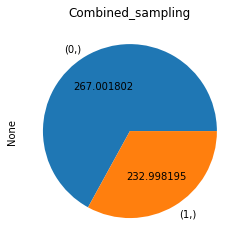

In [ ]:
#realiza o under e oversampling para os dados ficarem balanceados
smote_enn = SMOTEENN(random_state=0)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)


ax = y_train_res.value_counts().plot.pie(autopct='2%f')
_ = ax.set_title("Combined_sampling")

# Classificação

In [ ]:
model_gbm = GradientBoostingClassifier(n_estimators=600,
                                       learning_rate=0.05,
                                       max_depth=3,
                                       subsample=0.5,
                                       validation_fraction=0.1,
                                       n_iter_no_change=20,
                                       verbose=1)
model_gbm.fit(X_train_res, y_train_res)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.1974           0.0635            6.22m
         2           1.1224           0.0579            6.21m
         3           1.0845           0.0515            6.15m
         4           1.0319           0.0456            6.07m
         5           0.9846           0.0424            6.09m
         6           0.9588           0.0388            6.10m
         7           0.9361           0.0338            6.12m
         8           0.8966           0.0326            6.13m
         9           0.8644           0.0289            6.13m
        10           0.8192           0.0278            6.10m
        20           0.6169           0.0148            5.94m
        30           0.5387           0.0070            5.83m
        40           0.4468           0.0049            5.90m
        50           0.3972           0.0033            5.81m
        60           0.3668           0.0018            5.76m
       

GradientBoostingClassifier(learning_rate=0.05, n_estimators=600,
                           n_iter_no_change=20, subsample=0.5, verbose=1)

In [ ]:
model_prediction = model_gbm.predict(X_test)


print('accuracy %s' % accuracy_score(model_prediction, y_test))
print(classification_report(y_test, model_prediction))

accuracy 0.8493723849372385
              precision    recall  f1-score   support

           0       0.36      0.74      0.48        68
           1       0.97      0.86      0.91       649

    accuracy                           0.85       717
   macro avg       0.66      0.80      0.70       717
weighted avg       0.91      0.85      0.87       717



# Regressão

In [ ]:
target_reg = df2['weighted_vote_score']

In [ ]:
target_reg

74       0.583333
89       0.536785
107      0.666667
120      0.771310
123      0.654450
           ...   
96212    0.000000
96214    0.912740
96216    0.523810
96217    0.000000
96223    0.718310
Name: weighted_vote_score, Length: 3583, dtype: float64

In [ ]:
#separa o treino e o teste
X_train, X_test, y_train, y_test = train_test_split(features, target_reg, random_state=0, test_size=0.2)

In [ ]:
reg = GradientBoostingRegressor(n_estimators=600,
                                       learning_rate=0.05,
                                       max_depth=3,
                                       subsample=0.5,
                                       validation_fraction=0.1,
                                       n_iter_no_change=20,
                                       verbose=1)
reg.fit(X_train, y_train)



      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.0103           0.0001            4.28m
         2           0.0090           0.0001            4.33m
         3           0.0081           0.0001            4.29m
         4           0.0088           0.0000            4.31m
         5           0.0080           0.0001            4.31m
         6           0.0084           0.0000            4.32m
         7           0.0079           0.0000            4.34m
         8           0.0088           0.0000            4.36m
         9           0.0073           0.0000            4.37m
        10           0.0068           0.0000            4.37m
        20           0.0073           0.0000            4.24m
        30           0.0071          -0.0000            4.52m
        40           0.0072          -0.0000            4.33m


GradientBoostingRegressor(learning_rate=0.05, n_estimators=600,
                          n_iter_no_change=20, subsample=0.5, verbose=1)

In [ ]:
mse = mean_squared_error(y_test, reg.predict(X_test), squared = True)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.0084


In [ ]:
rmse = mean_squared_error(y_test, reg.predict(X_test), squared = False)
print("The Root mean squared error (RMSE) on test set: {:.4f}".format(rmse))

The Root mean squared error (RMSE) on test set: 0.0917


In [ ]:
y_pred = reg.predict(X_test)
df_preds = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred.squeeze()})
print(df_preds)

         Actual  Predicted
10555  0.266751   0.549768
7374   0.566487   0.581427
54411  0.507591   0.697718
45292  0.526814   0.579206
75533  0.634817   0.650717
...         ...        ...
71180  0.346541   0.554400
21711  0.341731   0.585859
25664  0.571226   0.583150
24849  0.491525   0.563821
7014   0.686353   0.620683

[717 rows x 2 columns]


# Importância dos atributos

In [ ]:
feat_imp_class = pd.DataFrame(model_gbm.feature_importances_)

In [ ]:
feat_imp_reg = pd.DataFrame(reg.feature_importances_)

In [ ]:
feat_imp_class.nlargest(n=10, columns=[0])

,0
0,0.478473
1095,0.048998
1005,0.013292
1016,0.013107
1094,0.010447
200,0.009212
402,0.008935
1024,0.008843
42,0.008702
895,0.007699


In [ ]:
feat_imp_reg.nlargest(n=10, columns=[0])

,0
0,0.084395
1042,0.049243
1094,0.042064
867,0.036206
1034,0.034609
386,0.032660
1043,0.029347
1024,0.028040
1014,0.025802
1023,0.021324


juntando o df do nome das features com o de valor

In [ ]:
transposto = features.transpose()

In [ ]:
lista_index = [transposto.index]

In [ ]:
index_df = pd.DataFrame(lista_index)

In [ ]:
df_feat = index_df.transpose()

In [ ]:
df_valor_feat_class = pd.concat([feat_imp_class, df_feat], axis=1)

In [ ]:
df_valor_feat_class

,0,0
0,0.478473,Recommended
1,0.000061,wv.1
2,0.000228,wv.2
3,0.000173,wv.3
4,0.000106,wv.4
...,...,...
1093,0.003052,n.sentences
1094,0.010447,n.words
1095,0.048998,avg.sentence.length
1096,0.000232,n.exclamation


In [ ]:
df_valor_feat_class.columns=['valor', 'feature'] #renomeando as colunas

In [ ]:
df_valor_feat_class

,valor,feature
0,0.478473,Recommended
1,0.000061,wv.1
2,0.000228,wv.2
3,0.000173,wv.3
4,0.000106,wv.4
...,...,...
1093,0.003052,n.sentences
1094,0.010447,n.words
1095,0.048998,avg.sentence.length
1096,0.000232,n.exclamation


In [ ]:
df_valor_feat_class.nlargest(n=10, columns=['valor'])

,valor,feature
0,0.478473,Recommended
1095,0.048998,avg.sentence.length
1005,0.013292,topic.5
1016,0.013107,topic.16
1094,0.010447,n.words
200,0.009212,wv.200
402,0.008935,wv.402
1024,0.008843,topic.24
42,0.008702,wv.42
895,0.007699,wv.895


In [ ]:
df_valor_feat_class.index.name= 'num_feat'

In [ ]:
classfeat = df_valor_feat_class.nlargest(n=10, columns=['valor'])

In [ ]:
classfeat

,valor,feature
num_feat,,
0,0.478473,Recommended
1095,0.048998,avg.sentence.length
1005,0.013292,topic.5
1016,0.013107,topic.16
1094,0.010447,n.words
200,0.009212,wv.200
402,0.008935,wv.402
1024,0.008843,topic.24
42,0.008702,wv.42


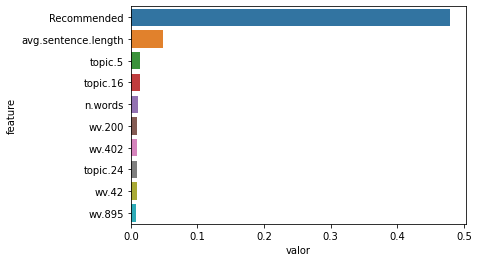

In [ ]:
sns.barplot(data=classfeat, x='valor', y='feature',)